<a href="https://colab.research.google.com/github/ashishsaini01/Anomaly_detection_using_autoencoders/blob/main/simple_auto_encoder_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from keras_preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pickle

import pandas as pd
import seaborn as sns

In [ ]:
# mounting google drive for easy data reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# minimize the data and reshape it to 128*128*1
a_file = open('/content/drive/MyDrive/Colab Notebooks/data_of_502_images(128).pkl', 'rb')
file_pic = pickle.load(a_file)

img_array = np.array(list(file_pic.values()))
img_array = img_array.astype('float32') / 255.0
img_array = np.reshape(img_array, (len(img_array), 128, 128, 1))

x_train = img_array[:2000]
x_test = img_array[2000:]

In [ ]:
x_train.shape, x_test.shape

((2000, 128, 128, 1), (510, 128, 128, 1))

In [ ]:
# Size of input image
Size = 128

In [ ]:
## ssim loss function (for anomoaly images ssim loss value is large) / (Structural Similarity between two images in terms of luminance, contrast, and structure)
def SSIMLoss(y_true, y_pred):
  ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
  brightness_average = tf.math.reduce_mean(y_pred, axis = (1, 2, 3))
  ssim_loss_bright = ssim_loss + tf.math.reduce_mean((brightness_average - 0.5)**2)
  # count = count + 1
  return ssim_loss_bright

In [ ]:
# Encoder
model = tf.keras.models.Sequential()

# Encoder (2 Conv - layers  architechture)
model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same', strides = 2, input_shape=(Size, Size, 1)))

model.add(tf.keras.layers.Conv2D(28, (5, 5), activation = 'relu', padding = 'same', strides = 2))

# Decoder
model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), activation='relu', padding='same', strides = 2))

model.add(tf.keras.layers.Conv2DTranspose(28, (5, 5), activation = 'relu', padding = 'same', strides = 2))

model.add(tf.keras.layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss= SSIMLoss)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode = 'min') # for early stopping

model.summary()

#Fit the model. 
history = model.fit(
        x_train, x_train,
        batch_size = 125,
        epochs=30,
        shuffle=True, callbacks=[callback],
        validation_data=(x_test, x_test))
# model.add(UpSampling2D((2, 2)))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1664      
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 28)        44828     
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 64)       44864     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 28)     44828     
 ranspose)                                                       
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 1)       701       
                                                                 
Total params: 136,885
Trainable params: 136,885
Non-tr

In [ ]:
# # # store the train model into pickle file
# a_file = open("/content/drive/MyDrive/Colab Notebooks/simple_model_with_sigmoid_ssimloss.pkl", "wb")
# pickle.dump(autoencoder, a_file)
# a_file.close()

INFO:tensorflow:Assets written to: ram://ac4244c3-48b9-46a4-9d2a-e242708b1163/assets


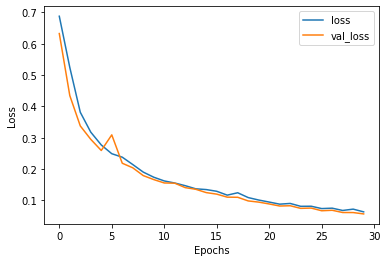

In [ ]:
# ploting 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()


In [ ]:
decoded_imgs = model.predict(x_test)
# decoded_imgs

Test images


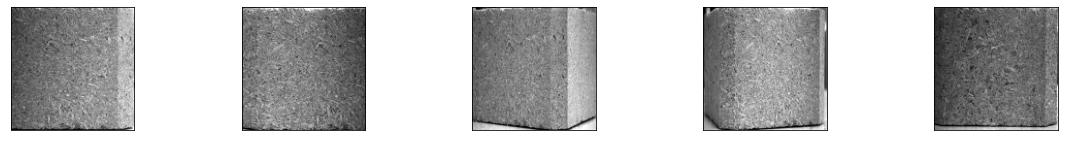

Reconstruction of test images


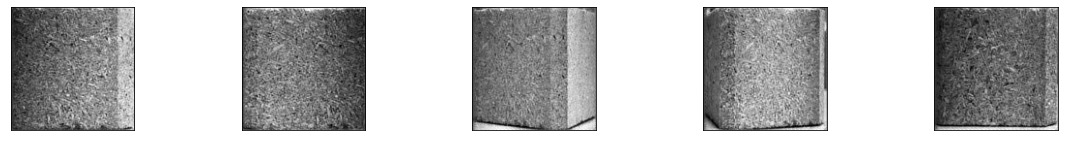

In [ ]:
n = 5
plt.figure(figsize=(20, 5))
print("Test images")
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print("Reconstruction of test images")
plt.figure(figsize=(20, 5))
for i in range(1, n + 1):
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
## For calculating the ssim between two images (in training it used differently)
def SSIMLoss_basic(y_true, y_pred):
  ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
  brightness_average = (tf.math.reduce_mean(y_true) + tf.math.reduce_mean(y_pred)) / 2
  ssim_loss_bright = ssim_loss + (brightness_average - 0.5)**2
  
  return ssim_loss_bright

In [ ]:
# calculating simm loss between orignal and reconstructed images
ssim_loss_ls = []
for i in range(0, len(x_test[0])):
  ssim_loss_ls.append(SSIMLoss_basic(x_test[i], x_test[i]))

ssim_df = pd.DataFrame(ssim_loss_ls, columns = ['SSIMLoss'])

smallest_loss = ssim_df.nsmallest(5, columns = ['SSIMLoss'])
largest_loss = ssim_df.nlargest(5, columns = ['SSIMLoss'])

min_index_ls = smallest_loss.index.tolist()
min_loss = smallest_loss.SSIMLoss.tolist()

max_index_ls = largest_loss.index.tolist()
max_loss = largest_loss.SSIMLoss.tolist()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


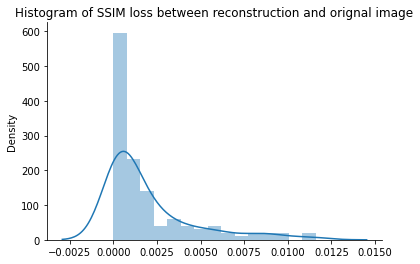

In [ ]:
ax = sns.distplot(ssim_loss_ls)
ax.set_title('Histogram of SSIM loss between reconstruction and orignal image')
sns.despine()

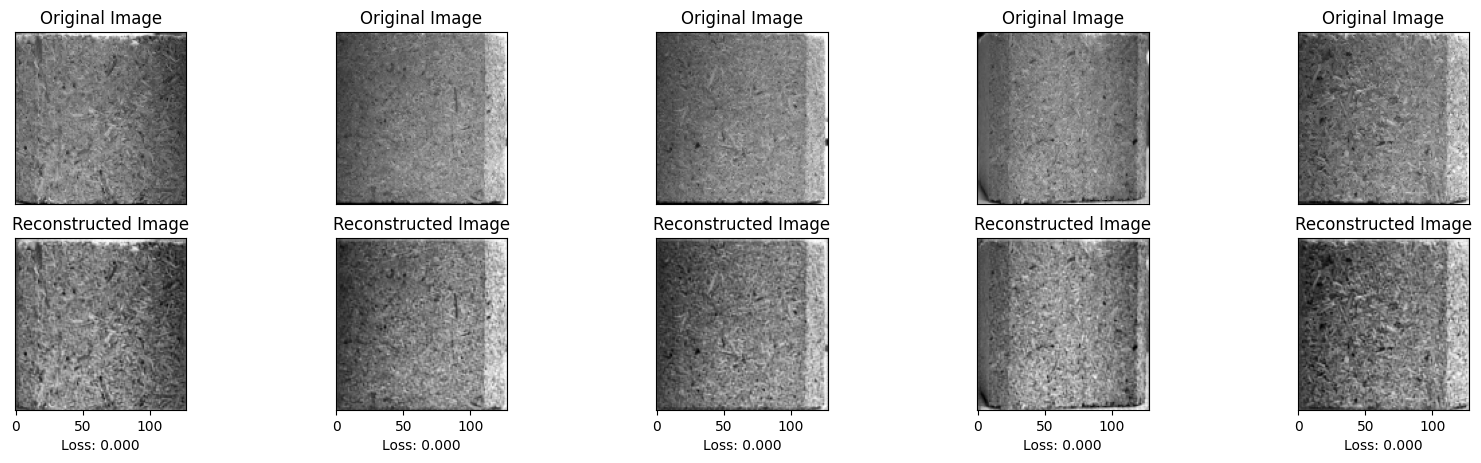

In [ ]:
# 5 orignal images and their reconstruction where the SSIM loss is minimum
n = 5
plt.figure(figsize=(20, 5), dpi=100)
for i in range(0, n):
    # Display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[min_index_ls[i]].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original Image")

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[min_index_ls[i]].reshape(128, 128))
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed Image")
    label = 'Loss: {:.3f}'
    ax.set_xlabel(label.format(min_loss[i]) )
    
plt.show()

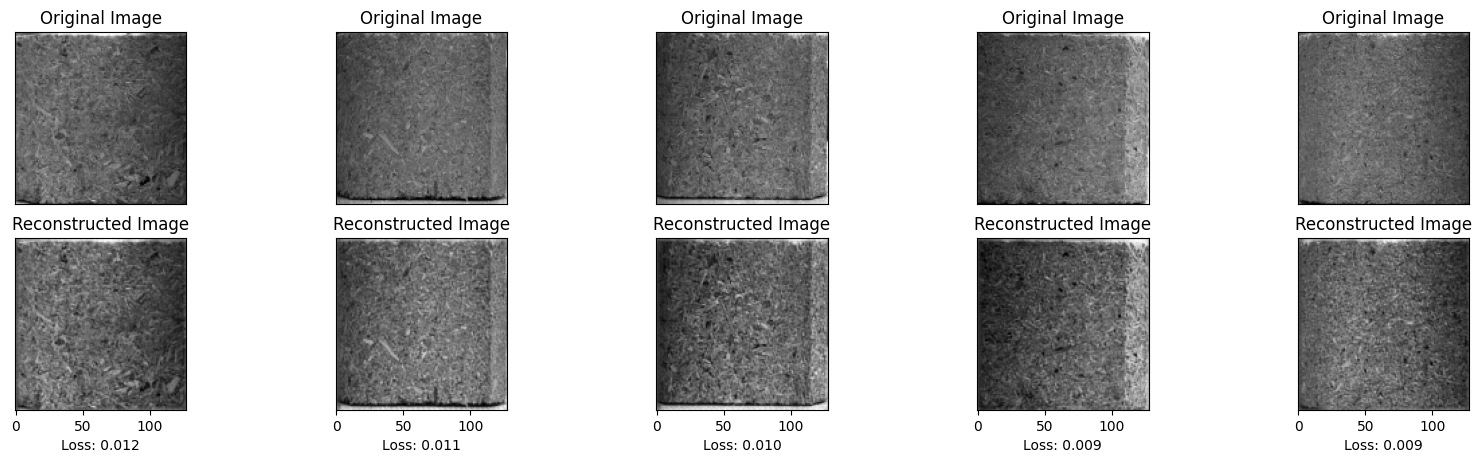

In [ ]:
# 5 orignal images and their reconstruction where the SSIM loss is high
n = 5
plt.figure(figsize=(20, 5), dpi=100)
for i in range(0, n):
    # Display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[max_index_ls[i]].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original Image")

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[max_index_ls[i]].reshape(128, 128))
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed Image")
    label = 'Loss: {:.3f}'
    ax.set_xlabel(label.format(max_loss[i]) )
    
plt.show()

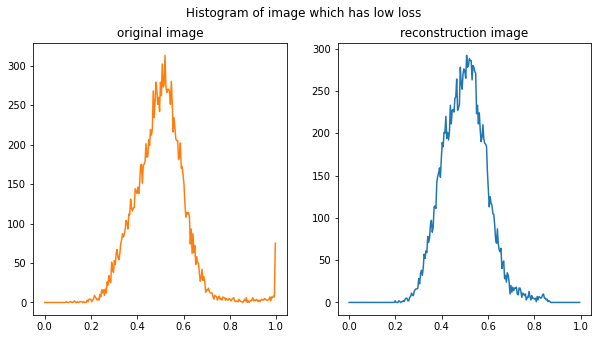

In [ ]:
histogram_1, bin_edges_1 = np.histogram(x_test[min_index_ls[0]].reshape(128,128), bins=256, range=(0, 1))
histogram, bin_edges = np.histogram(decoded_imgs[min_index_ls[0]].reshape(128,128), bins=256, range=(0, 1))

fig = plt.figure(figsize=(10,5))
fig.suptitle('Histogram of image which has low loss')
axes = fig.subplots(1, 2)

axes[0].plot(bin_edges_1[0:-1], histogram_1, 'tab:orange')
axes[0].set_title('original image')
axes[1].plot(bin_edges[0:-1], histogram)
axes[1].set_title('reconstruction image')

plt.show()


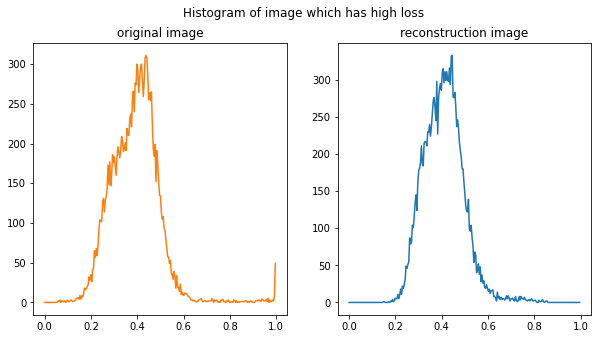

In [ ]:
histogram_1, bin_edges_1 = np.histogram(x_test[max_index_ls[0]].reshape(128,128), bins=256, range=(0, 1))
histogram, bin_edges = np.histogram(decoded_imgs[max_index_ls[0]].reshape(128,128), bins=256, range=(0, 1))

fig = plt.figure(figsize=(10,5))
fig.suptitle('Histogram of image which has high loss')
axes = fig.subplots(1, 2)

axes[0].plot(bin_edges_1[0:-1], histogram_1, 'tab:orange')
axes[0].set_title('original image')
axes[1].plot(bin_edges[0:-1], histogram)
axes[1].set_title('reconstruction image')

plt.show()